# Experiments
Simon Schellaert

This notebook contains code used to perform various experiments and analyses, such as tuning hyperparameters or plotting a learning curve. Since most of these experiments were performed ad hoc, the code may have to be modified slightly to perform a particular function.

## 0. Required dependencies ##

We start by including some packages that will be used in the remainder of the notebook. This prevents us from cluttering the other cells with imports.

In [13]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipilation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

#used to serialize python objects to disk and load them back to memory
import pickle

#plotting
import matplotlib.pyplot as plt

# helper functions kindly provided for you by Matthias 
import helpers
# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib notebook

# filepath constants
DATA_BASE_PATH = './'
OUTPUT_PATH='./'

DATA_TRAIN_PATH = os.path.join(DATA_BASE_PATH,'train')
DATA_TEST_PATH = os.path.join(DATA_BASE_PATH,'test')

FEATURE_BASE_PATH = os.path.join(OUTPUT_PATH,'features')
FEATURE_TRAIN_PATH = os.path.join(FEATURE_BASE_PATH,'train')
FEATURE_TEST_PATH = os.path.join(FEATURE_BASE_PATH,'test')

PREDICTION_PATH = os.path.join(OUTPUT_PATH,'predictions')

# filepatterns to write out features
FILEPATTERN_DESCRIPTOR_TRAIN = os.path.join(FEATURE_TRAIN_PATH,'train_features_{}.pkl')
FILEPATTERN_DESCRIPTOR_TEST = os.path.join(FEATURE_TEST_PATH,'test_features_{}.pkl')

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 50

## 1. Loading the data and the labels

In [7]:
folder_paths=glob.glob(os.path.join(DATA_TRAIN_PATH,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

In [8]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(DATA_TRAIN_PATH,label_string))) for label_string in label_strings)
test_paths = helpers.getImgPaths(DATA_TEST_PATH)

## 2. Loading the BoVW image features

To prevent code duplication, we define a few high-level functions that are used throughout the notebook for extracting features, creating feature vectors and creating a histogram.

In [26]:
# Returns an ordered list of all features corresponding to the images with the given paths
def extract_features_for_paths(all_features, paths):
    features = []
    
    for path in paths:
        features.append([feature for feature in all_features if feature.path == path][0])
    
    return features

In [27]:
# Returns a NumPy array containing the histogram feature given a list of image paths
def create_histogram_features(paths, number_of_bins = 10):
    features = []
    
    for path in paths:
        img = cv2.imread(path)
        hist = cv2.calcHist([img], [0, 1, 2], None, [number_of_bins, number_of_bins, number_of_bins], 3 * [0, 256]).flatten()
        features.append(hist / np.sum(hist))
        
    return np.array(features)

In [28]:
def convert_features_to_bow(features, codebook):
    bow_vectors = []
    
    for feature in features:
        bow_vector = helpers.encodeImage(feature.data, codebook)
        bow_vectors.append(bow_vector)

    return bow_vectors    

Next, we're ready to load the provided data. The remainder of this section is analogous to the section in `FinalModel.ipynb`.

In [29]:
with open(FILEPATTERN_DESCRIPTOR_TRAIN.format('sift'), 'rb') as pkl_file_train:
    train_features_from_pkl_sift = pickle.load(pkl_file_train)

with open(FILEPATTERN_DESCRIPTOR_TRAIN.format('daisy'), 'rb') as pkl_file_train:
    train_features_from_pkl_daisy = pickle.load(pkl_file_train)
    
assert len(train_features_from_pkl_sift) == len(train_features_from_pkl_daisy)

Number of encoded train images: 7112


Load the path of all training images and the corresponding label. Note that we skip the flipped images here. This allows us to explicitly disable or enable flipping images when performing cross-validation.

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

all_paths = []
all_labels = []

for image_features in train_features_from_pkl_sift:
    if '_flip.jpg' in image_features.path:
        continue
    all_paths.append(image_features.path)
    all_labels.append(image_features.label)
    
label_encoder = LabelEncoder()
label_encoder.fit(label_strings)
all_labels = label_encoder.transform(all_labels)

all_paths, all_labels = shuffle(np.array(all_paths), all_labels, random_state=42)

## Performing cross-validation

Using the data we loaded above, we can perform cross validation over one or more hyperparameters. In the example below, we cross validate the regularization hyperparameter. It is, however, simple to modify the code to cross validate over another hyperparameter.

In [31]:
config = {
    'sift_codebook_size': 2000,
    'daisy_codebook_size': 1000
    'flip_images': True,
    'regularization': 0.9
}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

# Shuffle all paths and the corresponding labels so we can just take a slice of these arrays
# to get a training set with the appropriate size.
all_paths, all_labels = shuffle(all_paths, all_labels, random_state=42)

losses = []

for regularization in [0.5, 1.0, 1.5, 2.0, 2.5]:
    selected_paths = all_paths[:train_size]
    selected_labels = all_labels[:train_size]
    
    skf = StratifiedKFold(n_splits=5, random_state=42)

    for train_index, test_index in skf.split(selected_paths, selected_labels):
        train_paths, test_paths = selected_paths[train_index], selected_paths[test_index]
        train_labels, test_labels = selected_labels[train_index], selected_labels[test_index]

        if config['flip_images']:
            train_paths_old, train_labels_old = train_paths, train_labels
            train_paths, train_labels = [], []

            for path, label in zip(train_paths_old, train_labels_old):
                train_paths.append(path)
                train_paths.append(path.replace('.jpg', '_flip.jpg'))
                train_labels.append(label)
                train_labels.append(label)

        train_features_sift = extract_features_for_paths(train_features_from_pkl_sift, train_paths)
        train_features_daisy = extract_features_for_paths(train_features_from_pkl_daisy, train_paths)
        train_data_hist = create_histogram_features(train_paths)

        test_features_sift = extract_features_for_paths(train_features_from_pkl_sift, test_paths)
        test_features_daisy = extract_features_for_paths(train_features_from_pkl_daisy, test_paths)
        test_data_hist = create_histogram_features(test_paths)

        # Note that we create the codebook only based on the training data
        codebook_sift = helpers.createCodebook(train_features_sift, codebook_size = config['sift_codebook_size'])
        codebook_daisy = helpers.createCodebook(train_features_daisy, codebook_size = config['daisy_codebook_size'])
    
        train_data_sift = convert_features_to_bow(train_features_sift, codebook_sift)
        train_data_daisy = convert_features_to_bow(train_features_daisy, codebook_daisy)

        test_data_sift = convert_features_to_bow(test_features_sift, codebook_sift)
        test_data_daisy = convert_features_to_bow(test_features_daisy, codebook_daisy)

        train_data = np.concatenate([train_data_sift, train_data_daisy, train_data_hist], axis=1)
        test_data = np.concatenate([test_data_sift, test_data_daisy, test_data_hist], axis=1)

        classifier = SVC(random_state=42, probability=True, kernel='linear', C=regularization)
        classifier.fit(train_data, train_labels)

        predictions = classifier.predict_proba(train_data)
        loss = log_loss(train_labels, predictions)
        losses.append('TRAIN loss for ' + str(regularization) + ' is ' + str(loss))
        
        predictions = classifier.predict_proba(test_data)
        loss = log_loss(test_labels, predictions)
        losses.append('TEST loss for ' + str(regularization) + ' is ' + str(loss))

## Plotting a confusion matrix

[[0.53968254 0.01587302 0.03174603 0.         0.15873016 0.01587302
  0.15873016 0.04761905 0.         0.03174603 0.        ]
 [0.07692308 0.20512821 0.1025641  0.         0.20512821 0.
  0.12820513 0.12820513 0.12820513 0.02564103 0.        ]
 [0.0326087  0.02173913 0.57608696 0.         0.2826087  0.
  0.04347826 0.02173913 0.01086957 0.01086957 0.        ]
 [0.0625     0.         0.25       0.625      0.0625     0.
  0.         0.         0.         0.         0.        ]
 [0.07692308 0.04807692 0.15384615 0.         0.57692308 0.
  0.07692308 0.03846154 0.01923077 0.         0.00961538]
 [0.04166667 0.         0.         0.         0.05555556 0.81944444
  0.04166667 0.         0.         0.04166667 0.        ]
 [0.09803922 0.         0.02941176 0.         0.07843137 0.
  0.75490196 0.00980392 0.         0.02941176 0.        ]
 [0.10666667 0.13333333 0.06666667 0.         0.2        0.
  0.04       0.30666667 0.14666667 0.         0.        ]
 [0.04       0.12       0.06       0.   

<IPython.core.display.Javascript object>


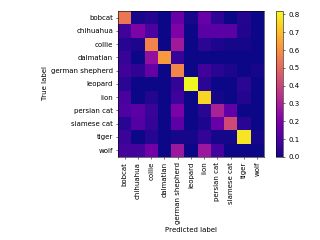

In [109]:
import itertools

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = [name.replace('_', ' ') for name in label_encoder.classes_]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.plasma)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Plotting the recall and accuracy per class

In [120]:
recall = []
accuracy = []

for i in range(11):
    recall.append(np.sum(predictions[test_labels == i] == i) / np.sum(test_labels == i))
    accuracy.append(np.sum(test_labels[predictions == i] == i) / np.sum(predictions == i))

<IPython.core.display.Javascript object>


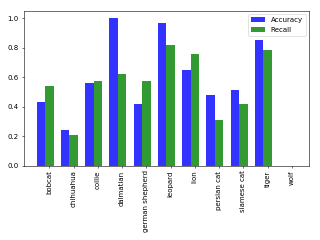

In [131]:
n_groups = label_encoder.classes_.shape[0]
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, accuracy, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Accuracy')
 
rects2 = plt.bar(index + bar_width, recall, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Recall')
 
plt.xticks(index + bar_width, classes, rotation=90)
plt.legend()
 
plt.tight_layout()
plt.savefig('accuracy.pdf', bbox_inches='tight')

## Plotting the class imbalance

<IPython.core.display.Javascript object>


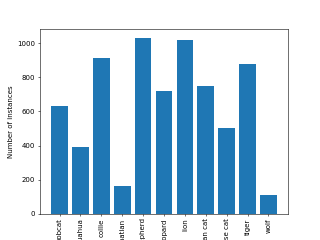

Text(0, 0.5, 'Number of instances')

In [10]:
# Skip the flipped version of images
classes = { k:list(filter(lambda x: '_flip.jpg' not in x, v)) for k, v in train_paths.items() }

class_names  = [name for name, images in classes.items()]
class_counts = [len(images) for name, images in classes.items()]

x = np.arange(0, len(class_counts))
plt.bar(x, class_counts)
plt.xticks(x, [name.replace('_', ' ') for name in class_names], rotation='vertical')

plt.ylabel('Number of instances')

## Plotting the first two LDA dimensions

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches

results = LinearDiscriminantAnalysis().fit_transform(train_data_sift, train_labels)
color_mapping = ['gold', 'red', 'grey', 'cyan', 'magenta', 'blue', 'sienna', 'orange', 'pink', 'green', 'purple']

plt.figure()

X_train, X_test, y_train, y_test = train_test_split(results, train_labels, test_size=0.10, random_state=42)
plt.scatter(X_test[:,0], X_test[:,1], c=[color_mapping[i] for i in y_test])

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')

plt.legend(handles=[mpatches.Patch(color=color, label=label.replace('_', ' ')) for color, label in zip(color_mapping, label_encoder.classes_)],
          bbox_to_anchor=(1.01, 0.88), loc=2, borderaxespad=0., frameon=False)

## Plotting a learning curve

The experiments above were adapted to only use a limited subset of the training data. The cross validation error was then computed for each training set size and the results are plotted below.

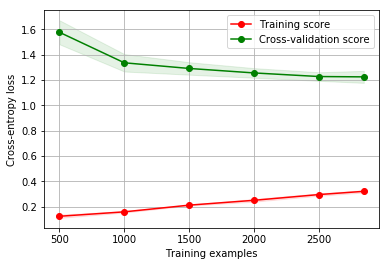

In [5]:
train_sizes = np.array([500, 1000, 1500, 2000, 2500, 2844])
train_scores = np.array([
    [0.12647612196148034, 0.12373006102406275, 0.13381535573806128, 0.10221425080170565, 0.14074135161101498],
    [0.1552554896257856, 0.15753164947690537, 0.16115835038085305, 0.15660327924362216, 0.17105699362644577],
    [0.2191400680745207, 0.21254410886924008, 0.211590383421446, 0.20849525004286248, 0.21438182874727763],
    [0.24832087437268865, 0.26740281113880116, 0.236462829731668, 0.25983232989165567, 0.2452546327907456],
    [0.3034534521196019, 0.3080136639400779, 0.3001013368494585, 0.28293003520987287, 0.2893062382246121],
    [0.33280602039375756, 0.32481625245062334, 0.3169071823425181, 0.32922950862277345, 0.306968263540809]])
                        
test_scores = np.array([
    [1.5824107894488115, 1.5758330541561274, 1.6401929990618809, 1.6831633170481983, 1.4047469554692478],
    [1.3481680142581707, 1.4640688695930288, 1.3063022023848057, 1.2936394116306473, 1.2694752814211276],
    [1.2740496780909352, 1.3031277263928935, 1.2086188649271374, 1.3558217043255658, 1.31671302084419],
    [1.2653999622700987, 1.1870169676969367, 1.2581402068854188, 1.2680223105741144, 1.3028919832018362],
    [1.2248126192901874, 1.1658090875621532, 1.234967108340172, 1.2651391697317975, 1.2486012324141986],
    [1.2099577602464713, 1.1866953765313373, 1.2425991991177547, 1.1785157611911512, 1.3089023028606062]
])

plt.figure()

plt.xlabel("Training examples")
plt.ylabel("Cross-entropy loss")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")